# Using SAS Event Stream Processing Python Interface to Load and Monitor ESP models

ESPPy is a pure Python package to connect to a SAS Event Stream Processing (ESP) server using the REST interface and web sockets.  The following notebook uses ESPPy to control and test the Rubik's model which scores cubes images sent via ESPPy from a python script which captures images from a webcam. 

API reference found here: 
https://sassoftware.github.io/python-esppy/

##  Table of Contents

    * Setup Libraries
    * Connect to ESP Server
    * Load Project
    * Subscribe to Event Streams
    * Visualize Data from Streams


## Import the ESPPy Package and Create a Connection

The ESP class is used to create the connection to the ESP server. Once you have a connection to the server, you can query it for information about projects (running and stopped) and the server itself. You can also create, load, start, stop, and delete projects.

In [26]:
import esppy
esp = esppy.ESP('http://iotdemo:61000')
esp

ESP('http://iotdemo:61000')

Tab-completion will show all of the methods and attributes on the ESP object.

## Server Introspection

In [27]:
esp.server_info

{'version': '6.1',
 'engine': '5928a362-d95b-4f3b-ad00-96a3c3b43d44',
 'analytics-license': True,
 'primary-server': True,
 'pubsub': 61001,
 'http': 61000,
 'loglevel': 'esp=error',
 'model': 'file://./rubix/rubix.xml'}

In [28]:
# display a list of currently loaded projects. 
esp.get_projects()

{'prog1': Project(name='prog1')}

In [4]:
# show project control 
esp.stop_project('prog1')
esp.delete_project('prog1')

## Load a Project

Projects can be loaded from file paths, Python file objects, or URLs. 

ESP.load_project(project, <overwrite= True | False>,<start= True | False>, <start_connectors= True | False>

In [7]:
#
# read the data from the URL
#
import urllib.request
# open a connection to a URL using urllib
webUrl  = urllib.request.urlopen('https://gitlab.sas.com/IOT/demos/computer-vision/rubixdl/raw/master/rubix.xml')

#get the result code and print it
print ("result code: " + str(webUrl.getcode()))

# read the data from the URL and print it
data = webUrl.read()
data = data.decode('UTF-8')  # decode bytes to str 
#print (data)


result code: 200


In [29]:
#project = esp.load_project(data)
project = esp.get_project('prog1')

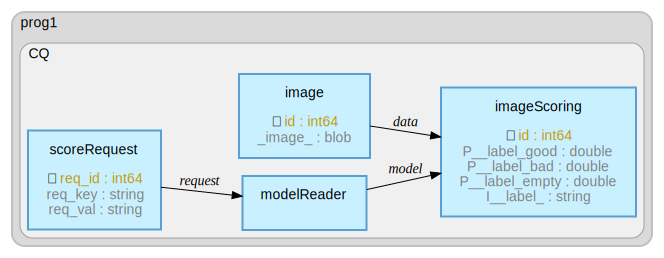

In [30]:
project.to_graph(schema=True)

### Get References to Project Components

In [32]:
project.queries

{'CQ': ContinuousQuery(name='CQ', project='prog1')}

In [33]:
project.queries['CQ'].windows

{'image': SourceWindow(name='image', contquery='CQ', project='prog1'), 'scoreRequest': SourceWindow(name='scoreRequest', contquery='CQ', project='prog1'), 'modelReader': ModelReaderWindow(name='modelReader', contquery='CQ', project='prog1'), 'imageScoring': ScoreWindow(name='imageScoring', contquery='CQ', project='prog1')}

#### Specifying `queries` and `windows` is optional.  The `Project` and `ContinuousQuery` objects act like dictionaries so you can access the sub-objects directly using indexing. 

In [34]:
imagewindow = project.queries['CQ'].windows['image']
scorewindow = project['CQ']['imageScoring']
str(scorewindow)

"ScoreWindow(name='imageScoring', contquery='CQ', project='prog1')"

In [11]:
str(imagewindow)

"SourceWindow(name='image', contquery='CQ', project='prog1')"

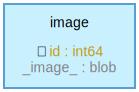

In [12]:
imagewindow.to_graph()

##  Subscriptions

We will now subscribe to the output of the score and image ESP windows.  This gives access to the event streams that are generated from these windows.  For the Image window it shows the image that was just send to ESP.  

In [35]:
# Only keep 5 events
scorewindow.subscribe(limit=5)

In [36]:
scorewindow.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 4 columns):
P__label_good     0 non-null float64
P__label_bad      0 non-null float64
P__label_empty    0 non-null float64
I__label_         0 non-null object
dtypes: float64(3), object(1)
memory usage: 0.0+ bytes


In [38]:
# Generates descriptive statistics that summarize the central tendency.
scorewindow.describe()

,P__label_good,P__label_bad,P__label_empty
count,5.000000,5.000000,5.000000
mean,0.391005,0.001195,0.607800
std,0.410861,0.002105,0.412405
min,0.003077,0.000012,0.021313
25%,0.013929,0.000051,0.403015
50%,0.367396,0.000138,0.632592
75%,0.596847,0.000865,0.986020
max,0.973778,0.004909,0.996058


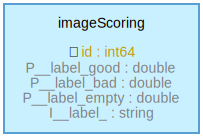

In [17]:
scorewindow

In [18]:
imagewindow.subscribe(limit=20)

You may have to wait a couple of seconds for the data to show up here.  If you execute the cell repeatedly, it will show the new events added each time.

In [19]:
imagewindow.describe()

,_image_
count,0
unique,0


## Streaming Data

### Using DataFrame Plotting Features

In [31]:
from esppy.plotting import *
streamChart=scorewindow.streaming_bar('id', ['P__label_good','P__label_bad'],
                                 label=['Solved', 'Messed'],
                                 x_axis_label= 'Iteration',
                                 y_axis_label= 'Percentage',
                                 title="Rubiks Results")
streamChart

In [39]:
esppy.plotting.StreamingImages
streamimage=imagewindow.streaming_images('_image_',                                                         
                                 title="Picture")
streamimage

In [81]:
streamline=scorewindow.streaming_line('id', ['P__label_good','P__label_bad'],
                                   label=['Solved', 'Messed'],
                                   steps=100000.0,
                                   interval=1000,
                                   max_data=3)
streamline

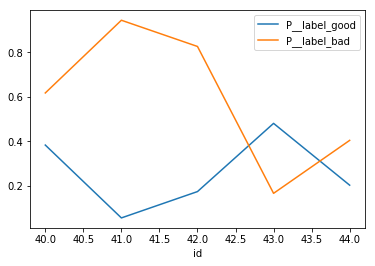

In [22]:
%matplotlib inline
scorewindow.plot(y=['P__label_good','P__label_bad']) 